In [21]:
'''
__author__ = 'Alex Cheng'
Python集成方法工具包解决分类问题：梯度提升法 处理玻璃多分类 数据不平衡 问题
ensemble: RandomForestClassifier,
回归：分割点质量是有平方误差和（mse）
分类：误分类指标，ROC曲线，误分类率
predict,predic_proba,predict_log_proba

梯度提升算法会过拟合，持续跟踪AUC最佳值，其最佳值生成ROC曲线，fpr,tpr等
决策树数目的增加就等同于在梯度下降中采取了更多步骤，每一步就意味着又训练了一个决策树

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets,linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve,auc,roc_auc_score,mean_squared_error, \
accuracy_score,confusion_matrix
from math import sqrt
import random

In [13]:
path = 'd:/input/jobs/'
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "glass/glass.data")
df = pd.read_csv(target_url,header=None,prefix="V")
#df = pd.read_csv(target_url)
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Index(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'], dtype='object')

In [42]:
# 原始数组
xList  = np.array(df.iloc[:,1:-1]) # 属性数组,第一列是标号没有意义
#labels = [i for i in df.iloc[:,-1]] # 最后一列就是label
# 标签是整数值，转换成连续整数
labels = df.iloc[:,-1]
newLabels = []
labelSet = set(labels)
labelList = list(labelSet)
labelList.sort()
for i in labels:
    index = labelList.index(i)
    newLabels.append(index)

# 字典编码
labelCode = {}
for k,v in zip(labelList,range(len(labelList))):
    labelCode[k] = v
print(labelCode)
print(df.iloc[:,-1].value_counts())
'''
2    76
1    70
7    29
3    17
5    13
6     9
Name: V10, dtype: int64
'''

glassNames = np.array(['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type'])



{1: 0, 2: 1, 3: 2, 5: 3, 6: 4, 7: 5}
2    76
1    70
7    29
3    17
5    13
6     9
Name: V10, dtype: int64


In [50]:
# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# RandomForest 要求数据为np.array格式
x = np.array(df.iloc[:,:-1])
y = np.array(newLabels)
#names = np.array(df.columns)

# 标签分布不均匀，随机抽样有可能不能保持总体的分布，采
# 用分层抽样技术（stratifid sampleing）
# model_selection
# 每类标签选30%，先选一个算是初始化np.array, 为下面的np.append(x,xt,aix=0)为准备
xTemp = [xList[i] for i in range(nrows) if newLabels[i] == 0] # 类数量最多的
yTemp = [newLabels[i] for i in range(nrows) if newLabels[i] == 0]
xTrain,xTest,yTrain,yTest = train_test_split(xTemp,yTemp,test_size=0.30,random_state=828)

for label in range(1,len(labelList)): # 0以后其它标签类也按30%比例
    xTemp = [xList[i] for i in range(nrows) if newLabels[i] == label]
    yTemp = [newLabels[i] for i in range(nrows) if newLabels[i] == label]
    xTrainTemp,xTestTemp,yTrainTemp,yTestTemp = train_test_split(
        xTemp,yTemp,test_size=0.30,random_state=828)
    # 累计最终结果
    xTrain = np.append(xTrain,xTrainTemp,axis=0)
    xTest =  np.append(xTest,xTestTemp,axis=0)
    yTrain = np.append(yTrain,yTrainTemp,axis=0)
    yTest =  np.append(yTest,yTestTemp,axis=0)

error = []
nTreeList = range(50,2000,50)
for iTree in nTreeList:
    depth = None
    maxFeat = 4
    glassRF = ensemble.RandomForestClassifier(n_estimators=iTree, max_depth=depth,
                    max_features=maxFeat,oob_score=False,random_state=828)
    glassRF.fit(xTrain,yTrain)
    
    pred = glassRF.predict(xTest) # 结果是numpy格式
    acc = accuracy_score(yTest,pred)
    error.append(1.0-acc)


In [55]:
error[:5],pred[:5]

([0.28787878787878785,
  0.24242424242424243,
  0.25757575757575757,
  0.25757575757575757,
  0.28787878787878785],
 array([5, 0, 0, 0, 0]))

In [52]:
print(len(yTest),len(pred))

66 66


Miss classification Error:  0.28787878787878785

Confusion Matrix: 
 [[19  1  0  0  0  1]
 [ 6 15  0  1  0  1]
 [ 3  2  1  0  0  0]
 [ 0  1  0  2  0  1]
 [ 0  0  0  0  3  0]
 [ 1  1  0  0  0  7]]


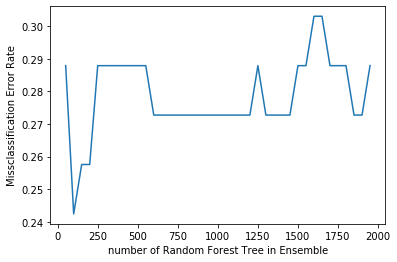

In [53]:
print('Miss classification Error: ',error[-1])
pList = pred.tolist()
# 混淆矩阵(本例是多分类)，对于每一个类别，其样本分别有多少被预测成了其他类别
confMat = confusion_matrix(yTest,pred)
print('')
print('Confusion Matrix: \n',confMat)

# 训练集，测试集错误率 vs 树的数量
plt.plot(nTreeList,error)
plt.xlabel('number of Random Forest Tree in Ensemble')
plt.ylabel('Missclassification Error Rate')
plt.show()

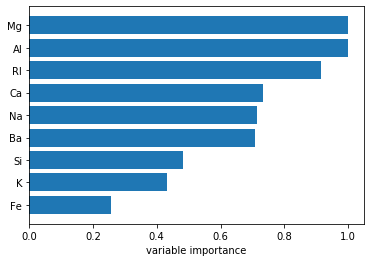

In [54]:
# 特征重要性,top30
featImportance = glassRF.feature_importances_
featImportance = featImportance / featImportance.max()
#print(len(featImportance))
idxSorted = np.argsort(featImportance) # 后面最大60-40个
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos,featImportance[idxSorted], align='center') # 水平柱状图
plt.yticks(barPos, glassNames[idxSorted]) # np.array的数组可以[]取值
plt.xlabel('variable importance')
#plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.1)
plt.show()
# 条状图中有些属性对性能的贡献是相当有些的，这不同寻常，在很多情况下，属性的重要性
# 经过前几个后会迅速下降，但是对玻璃分类，有几个属性具有相同的重要性